In [1]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.1 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [5]:
def read_image(path):
  # TODO: Open the image in RGB format and convert into numpy array

  image = Image.open(path).convert('RGB')
  image = np.asarray(image)

  # TODO: Normalize the image
  image = image/255
  return image

In [7]:
image = read_image('image.png')
# TODO: Get shape of image
image.shape

(382, 774, 3)

In [8]:
original_bytes = image.nbytes
print ("The space (in bytes) needed to store this image is", original_bytes)

The space (in bytes) needed to store this image is 7096032


In [9]:
def SVD_channels(image):
  # TODO: Separate the channels of the image
  image_red = image[:, :, 0]
  image_green = image[:, :, 1]
  image_blue = image[:, :, 2]

  # Perform SVD on each channel
  U_r, S_r, V_r = np.linalg.svd(image_red, full_matrices=True)
  U_g, S_g, V_g = np.linalg.svd(image_green, full_matrices=True)
  U_b, S_b, V_b = np.linalg.svd(image_blue, full_matrices=True)
  
  return U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b

In [10]:
U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b = SVD_channels(image)
bytes_to_be_stored = sum([matrix.nbytes for matrix in [U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b]])
print ("The matrices that we store have total size (in bytes):", bytes_to_be_stored)

The matrices that we store have total size (in bytes): 17889168


In [14]:
def TopK_Eigen(U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b, k):
  # TODO: Use only top K eignevectors. Top K in U, S, V in all channels

  U_r_k = U_r[:, 0:k]
  V_r_k = V_r[0:k, :]
  U_g_k = U_g[:, 0:k]
  V_g_k = V_g[0:k, :]
  U_b_k = U_b[:, 0:k]
  V_b_k = V_b[0:k, :]

  S_r_k = S_r[0:k]
  S_g_k = S_g[0:k]
  S_b_k = S_b[0:k]

  return U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k

In [15]:
U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k = TopK_Eigen(U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b, k=50)

compressed_bytes = sum([matrix.nbytes for matrix in [U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k]])
print ("The compressed matrices that we store now have total size (in bytes):", compressed_bytes)

The compressed matrices that we store now have total size (in bytes): 1388400


In [16]:
ratio = compressed_bytes / original_bytes
print ("The compression ratio between the original image size and the total size of the compressed factors is", ratio)

The compression ratio between the original image size and the total size of the compressed factors is 0.19565864415493053


In [17]:
def reconstruct(U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k):
  # TODO: Reconstruct the image from compressed U, S, V matrices.

  image_red_approx = np.dot(U_r_k, np.dot(np.diag(S_r_k), V_r_k))
  image_green_approx = np.dot(U_g_k, np.dot(np.diag(S_g_k), V_g_k))
  image_blue_approx = np.dot(U_b_k, np.dot(np.diag(S_b_k), V_b_k))

  image_approx = np.zeros((382, 774, 3))

  image_approx[:, :, 0] = image_red_approx
  image_approx[:, :, 1] = image_green_approx
  image_approx[:, :, 2] = image_blue_approx

  return image_approx

In [18]:
image_reconstructed = reconstruct(U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k)

image_reconstructed[image_reconstructed < 0] = 0
image_reconstructed[image_reconstructed > 1] = 1

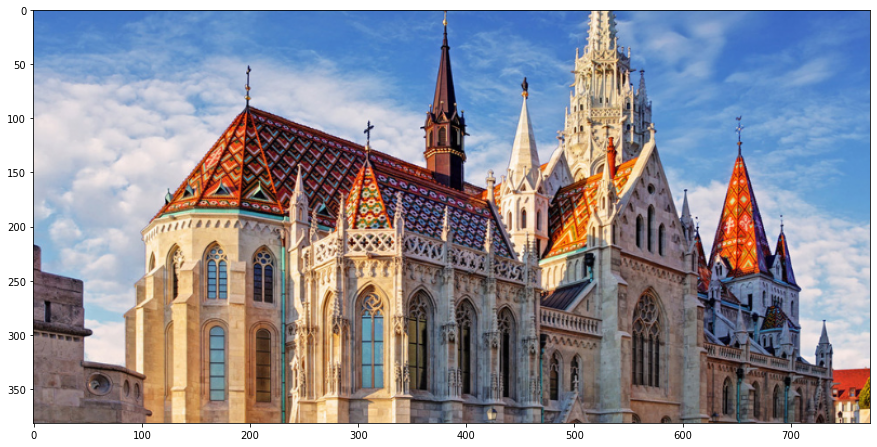

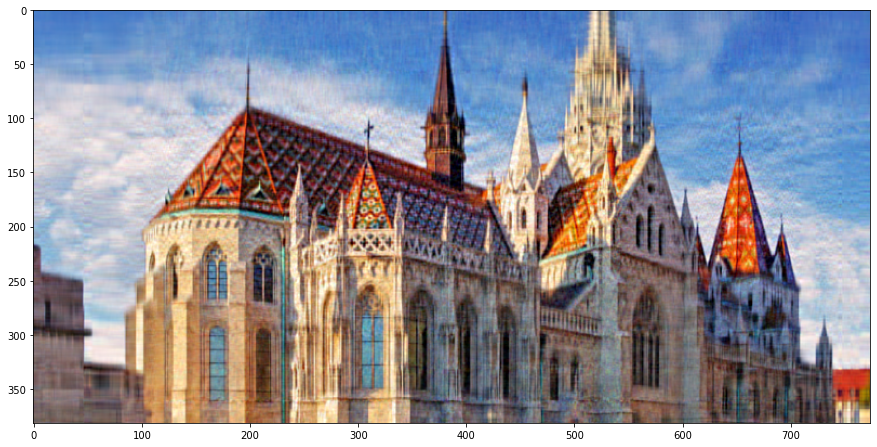

In [19]:
# fig = plt.figure(figsize=(15, 10))
# a = fig.add_subplot(1, 1, 1)
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.figure(figsize=(15, 10))
plt.imshow(image_reconstructed)
# a.set_title('Castle hill, compressed image using the best rank-{} approximation'.format(k))
# plt.show()

In [21]:
@interact(k=widgets.IntSlider(min=0, max=300, step=5))
def image_compressor(k):
  image = read_image('image.png')
  U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b = SVD_channels(image)

  U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k = TopK_Eigen(U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b, k)

  image_reconstructed = reconstruct(U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k)

  image_reconstructed[image_reconstructed < 0] = 0
  image_reconstructed[image_reconstructed > 1] = 1

  plt.figure(figsize=(15, 10))

  plt.imshow(image_reconstructed)

# interact(image_compressor);

interactive(children=(IntSlider(value=0, description='k', max=300, step=5), Output()), _dom_classes=('widget-i…